# Run toy example: 5 trials of 100 generation of host population; diverse free-living population

In [ ]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
#sys.path.append("/home/qiulab/data/CRF_project/work/Modeling_trophosome/src/")

from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.update_pop import update_pop3
from project_package.run_model import run_generation_of_host_pop
from project_package.plot import visualize_pop
from project_package.simplify import merge_graphs

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time


# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-12
growth_factor=1.2
steady_state_runtime=50
max_runtime=np.inf
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

## params run_host_pop_gen
n_worms=10
infection_sym_count=10
tot_host_pop_gen=100
escape_rate=1E-2
n_trials=5
cpus=4

# init tree log-fisher
init_pop_strains=100
is_init_pop_log_fisher=True

if is_init_pop_log_fisher==True:  
    freelivingG=generate_random_fisherlog_pop_unlinked(i=init_pop_strains) #n=individuals, i=strains
    freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(init_pop_strains)]))
    
## init tree

# fitnesses=[0.95,0.9] # allele_id:fitness
# abundances=[300000000,700000000] # allele_id:abundance # total 1G cells
# freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
# freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG




myparams=['## params grow_and_steady',
'mutation_rate='+str(mutation_rate),
'growth_factor='+str(growth_factor),
'steady_state_runtime='+str(steady_state_runtime),
'max_runtime='+str(max_runtime),
'pop_size_thr='+str(pop_size_thr),
'simplify='+str(simplify),
'verbose='+str(verbose),
'sampling_rate='+str(sampling_rate),
'',
'## params run_host_pop_gen',
'n_worms='+str(n_worms),
'infection_sym_count='+str(infection_sym_count),
'tot_host_pop_gen='+str(tot_host_pop_gen),
'escape_rate='+str(escape_rate),
'n_trials='+str(n_trials),
'cpus='+str(cpus),
'',
'## init tree',
'fitnesses='+str(fitnesses),
'abundances='+str(abundances),
'init_pop_strains='+str(init_pop_strains),
'is_init_pop_log_fisher='+str(is_init_pop_log_fisher)]


print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


###############################
## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

start_time=time.time()

with alive_bar((tot_host_pop_gen+1) * n_trials ,force_tty=True) as bar:
    for trial in range(n_trials):
        host_pop_gen=0
        time_series_freeliving[trial]=[freelivingG]
        time_series_hostassociated[trial]=[nx.Graph()]
        myfreelivingG=freelivingG.copy()
    
        for host_pop_gen in range(1,tot_host_pop_gen+1):
        
            merged_Graph_hostassociated, merged_Graph_freeliving,_=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                 mutation_rate, steady_state_runtime,
                                 max_runtime, growth_factor=growth_factor,
                                 stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                 verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=cpus)
            
            time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
            time_series_freeliving[trial]+=[merged_Graph_freeliving]
            myfreelivingG=merged_Graph_freeliving
            
            bar() 
print('finished')

print('it took', time.time()-start_time, 'seconds')

###########


dump_dir='../examples/'
test='toy_example'

with open(dump_dir+test+'.input_params.txt','w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

    

In [21]:
import pickle
from project_package.generate_pop import SymPop

%reload_ext autoreload
%autoreload 2
    
# dump_dir='../examples/'
dump_dir='./'

test='toy_example'

with open(dump_dir+test+'.input_params.txt','w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)


df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    # time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['eveness','pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['eveness','pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])    

/Users/maeva/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maeva/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


     pop_size  richness      metapop trial
97   10973000        42  free-living     4
98   11086070        42  free-living     4
99   11199140        42  free-living     4
100  11312310        42  free-living     4


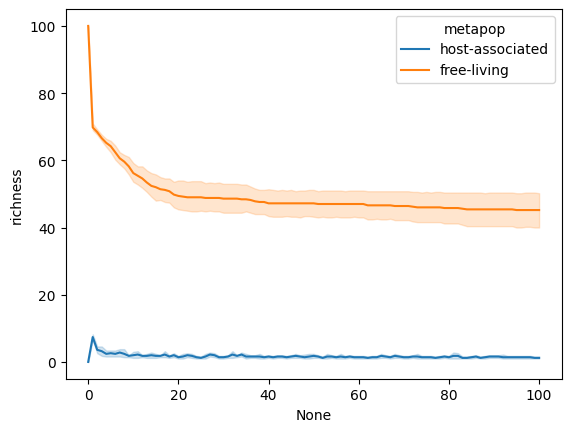

In [25]:
import seaborn as sns

sns.lineplot(data=df,x=df.index,y='richness',hue='metapop')
plt.savefig(dump_dir+test+".plot.svg", format='svg')

# all in one

## initial symbiont diversity (init_pop_strains=100)

4031
|███████████████████████████████████████▋⚠︎ (!) 500/505 [99%] in 12:53.5 (0.65/s)
finished
it took 773.59223985672 seconds


/Users/maeva/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maeva/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


      pop_size  richness      metapop trial
97   109773981        54  free-living     4
98   110905631        54  free-living     4
99   112037281        54  free-living     4
100  113169031        54  free-living     4


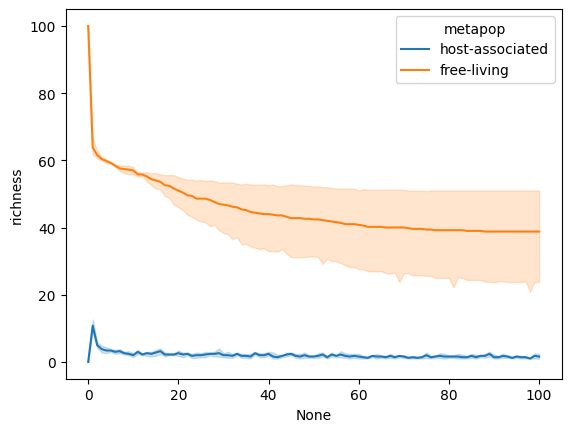

In [28]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
#sys.path.append("/home/qiulab/data/CRF_project/work/Modeling_trophosome/src/")

from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.update_pop import update_pop3
from project_package.run_model import run_generation_of_host_pop
from project_package.plot import visualize_pop
from project_package.simplify import merge_graphs

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time


# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-12
growth_factor=1.2
steady_state_runtime=50
max_runtime=np.inf
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

## params run_host_pop_gen
n_worms=10
infection_sym_count=10
tot_host_pop_gen=100
escape_rate=1E-1
n_trials=5
cpus=4

# init tree log-fisher
init_pop_strains=100
is_init_pop_log_fisher=True

if is_init_pop_log_fisher==True:  
    freelivingG=generate_random_fisherlog_pop_unlinked(i=init_pop_strains) #n=individuals, i=strains
    freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(init_pop_strains)]))
    
## init tree

# fitnesses=[0.95,0.9] # allele_id:fitness
# abundances=[300000000,700000000] # allele_id:abundance # total 1G cells
# freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
# freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG




myparams=['## params grow_and_steady',
'mutation_rate='+str(mutation_rate),
'growth_factor='+str(growth_factor),
'steady_state_runtime='+str(steady_state_runtime),
'max_runtime='+str(max_runtime),
'pop_size_thr='+str(pop_size_thr),
'simplify='+str(simplify),
'verbose='+str(verbose),
'sampling_rate='+str(sampling_rate),
'',
'## params run_host_pop_gen',
'n_worms='+str(n_worms),
'infection_sym_count='+str(infection_sym_count),
'tot_host_pop_gen='+str(tot_host_pop_gen),
'escape_rate='+str(escape_rate),
'n_trials='+str(n_trials),
'cpus='+str(cpus),
'',
'## init tree',
'fitnesses='+str(fitnesses),
'abundances='+str(abundances),
'init_pop_strains='+str(init_pop_strains),
'is_init_pop_log_fisher='+str(is_init_pop_log_fisher)]


print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


###############################
## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

start_time=time.time()

with alive_bar((tot_host_pop_gen+1) * n_trials ,force_tty=True) as bar:
    for trial in range(n_trials):
        host_pop_gen=0
        time_series_freeliving[trial]=[freelivingG]
        time_series_hostassociated[trial]=[nx.Graph()]
        myfreelivingG=freelivingG.copy()
    
        for host_pop_gen in range(1,tot_host_pop_gen+1):
        
            merged_Graph_hostassociated, merged_Graph_freeliving,_=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                 mutation_rate, steady_state_runtime,
                                 max_runtime, growth_factor=growth_factor,
                                 stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                 verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=cpus)
            
            time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
            time_series_freeliving[trial]+=[merged_Graph_freeliving]
            myfreelivingG=merged_Graph_freeliving
            
            bar() 
print('finished')

print('it took', time.time()-start_time, 'seconds')

###########


dump_dir='../examples/'
test='toy_example_high_escaperate'

with open(dump_dir+test+'.input_params.txt', 'w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)


df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    # time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])  

import seaborn as sns

sns.lineplot(data=df,x=df.index,y='richness',hue='metapop')
plt.savefig(dump_dir+test+".plot.svg", format='svg')

## larger initial symbiont diversity (init_pop_strains=100000)

In [ ]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
#sys.path.append("/home/qiulab/data/CRF_project/work/Modeling_trophosome/src/")

from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.update_pop import update_pop3
from project_package.run_model import run_generation_of_host_pop
from project_package.plot import visualize_pop
from project_package.simplify import merge_graphs

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time


# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-12
growth_factor=1.2
steady_state_runtime=50
max_runtime=np.inf
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

## params run_host_pop_gen
n_worms=10
infection_sym_count=10
tot_host_pop_gen=100
escape_rate=1E-2
n_trials=5
cpus=4

# init tree log-fisher
init_pop_strains=100000
is_init_pop_log_fisher=True

if is_init_pop_log_fisher==True:  
    freelivingG=generate_random_fisherlog_pop_unlinked(i=init_pop_strains) #n=individuals, i=strains
    freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(init_pop_strains)]))
    
## init tree

# fitnesses=[0.95,0.9] # allele_id:fitness
# abundances=[300000000,700000000] # allele_id:abundance # total 1G cells
# freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
# freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG




myparams=['## params grow_and_steady',
'mutation_rate='+str(mutation_rate),
'growth_factor='+str(growth_factor),
'steady_state_runtime='+str(steady_state_runtime),
'max_runtime='+str(max_runtime),
'pop_size_thr='+str(pop_size_thr),
'simplify='+str(simplify),
'verbose='+str(verbose),
'sampling_rate='+str(sampling_rate),
'',
'## params run_host_pop_gen',
'n_worms='+str(n_worms),
'infection_sym_count='+str(infection_sym_count),
'tot_host_pop_gen='+str(tot_host_pop_gen),
'escape_rate='+str(escape_rate),
'n_trials='+str(n_trials),
'cpus='+str(cpus),
'',
'## init tree',
'fitnesses='+str(fitnesses),
'abundances='+str(abundances),
'init_pop_strains='+str(init_pop_strains),
'is_init_pop_log_fisher='+str(is_init_pop_log_fisher)]


print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


###############################
## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

start_time=time.time()

with alive_bar((tot_host_pop_gen+1) * n_trials ,force_tty=True) as bar:
    for trial in range(n_trials):
        host_pop_gen=0
        time_series_freeliving[trial]=[freelivingG]
        time_series_hostassociated[trial]=[nx.Graph()]
        myfreelivingG=freelivingG.copy()
    
        for host_pop_gen in range(1,tot_host_pop_gen+1):
        
            merged_Graph_hostassociated, merged_Graph_freeliving,_=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                 mutation_rate, steady_state_runtime,
                                 max_runtime, growth_factor=growth_factor,
                                 stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                 verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=cpus)
            
            time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
            time_series_freeliving[trial]+=[merged_Graph_freeliving]
            myfreelivingG=merged_Graph_freeliving
            
            bar() 
print('finished')

print('it took', time.time()-start_time, 'seconds')

###########


dump_dir='../examples/'
test='toy_example2_high_escaperate'

with open(dump_dir+test+'.input_params.txt', 'w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_freeliving, handle)


df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    # time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])  

import seaborn as sns

sns.lineplot(data=df,x=df.index,y='richness',hue='metapop')
plt.savefig(dump_dir+test+".plot.svg", format='svg')

In [30]:
dump_dir='../examples/'
test='toy_example2'

with open(dump_dir+test+'.input_params.txt', 'w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_freeliving, handle)

In [ ]:
dump_dir='../examples/'
test='toy_example2'

import pandas as pd
import pickle

time_series_hostassociated = pd.read_pickle(dump_dir+test+'.time_series_freeliving.txt')
time_series_freeliving = pd.read_pickle(dump_dir+test+'.time_series_freeliving.txt')

df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    # time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['eveness','pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['eveness','pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])    

## no hosts (1 worm ,all free-living strains)

In [75]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
#sys.path.append("/home/qiulab/data/CRF_project/work/Modeling_trophosome/src/")

from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.update_pop import update_pop3
from project_package.run_model import run_generation_of_host_pop
from project_package.plot import visualize_pop
from project_package.simplify import merge_graphs

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time
import warnings
warnings.filterwarnings('ignore')

# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-3
growth_factor=1
steady_state_runtime=50
max_runtime=1
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

# init tree log-fisher
fitnesses=[]
abundances=[]

init_pop_strains=100
is_init_pop_log_fisher=True
if is_init_pop_log_fisher==True:  
    freelivingG=generate_random_fisherlog_pop_unlinked(i=init_pop_strains) #n=individuals, i=strains
    freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(init_pop_strains)]))

## params run_host_pop_gen
n_worms=1
infection_sym_count= SymPop(freelivingG).pop_size
tot_host_pop_gen=2
escape_rate=1
n_trials=5
cpus=1



## init tree

# fitnesses=[0.95,0.9] # allele_id:fitness
# abundances=[300000000,700000000] # allele_id:abundance # total 1G cells
# freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
# freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG




myparams=['## params grow_and_steady',
'mutation_rate='+str(mutation_rate),
'growth_factor='+str(growth_factor),
'steady_state_runtime='+str(steady_state_runtime),
'max_runtime='+str(max_runtime),
'pop_size_thr='+str(pop_size_thr),
'simplify='+str(simplify),
'verbose='+str(verbose),
'sampling_rate='+str(sampling_rate),
'',
'## params run_host_pop_gen',
'n_worms='+str(n_worms),
'infection_sym_count='+str(infection_sym_count),
'tot_host_pop_gen='+str(tot_host_pop_gen),
'escape_rate='+str(escape_rate),
'n_trials='+str(n_trials),
'cpus='+str(cpus),
'',
'## init tree',
'fitnesses='+str(fitnesses),
'abundances='+str(abundances),
'init_pop_strains='+str(init_pop_strains),
'is_init_pop_log_fisher='+str(is_init_pop_log_fisher)]


print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


###############################
## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

start_time=time.time()

with alive_bar((tot_host_pop_gen+1) * n_trials ,force_tty=True) as bar:
    for trial in range(n_trials):
        host_pop_gen=0
        time_series_freeliving[trial]=[freelivingG]
        time_series_hostassociated[trial]=[nx.Graph()]
        myfreelivingG=freelivingG.copy()
    
        for host_pop_gen in range(1,tot_host_pop_gen+1):
        
            merged_Graph_hostassociated, merged_Graph_freeliving,_=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                 mutation_rate, steady_state_runtime,
                                 max_runtime, growth_factor=growth_factor,
                                 stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                 verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=cpus)
            
            time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
            time_series_freeliving[trial]+=[merged_Graph_freeliving]
            myfreelivingG=merged_Graph_freeliving
            
            bar() 
print('finished')

print('it took', time.time()-start_time, 'seconds')

###########

import pickle
dump_dir='../examples/'
test='toy_example3_VeryLarge_init_pop_richness'

with open(dump_dir+test+'.input_params.txt', 'w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_freeliving, handle)




3955
|██████████████████████████▋⚠︎            | (!) 10/15 [67%] in 8.7s (1.10/s)     
finished
it took 8.66255784034729 seconds


   pop_size  richness          metapop trial
2      3948        36  host-associated     4
0      3955       100      free-living     4
1       -10        32      free-living     4
2      3938        61      free-living     4


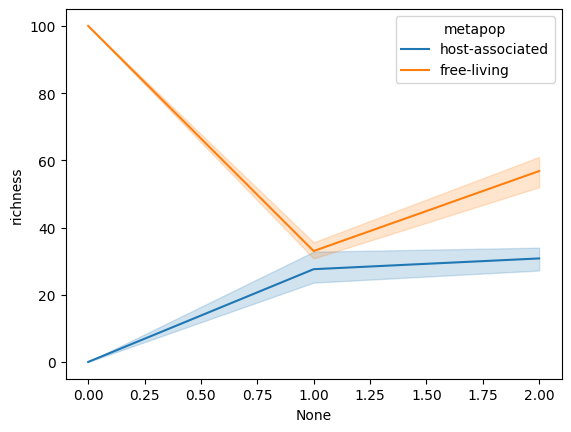

In [76]:
df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    # time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])  

import seaborn as sns

sns.lineplot(data=df,x=df.index,y='richness',hue='metapop')
plt.savefig(dump_dir+test+".plot.svg", format='svg')

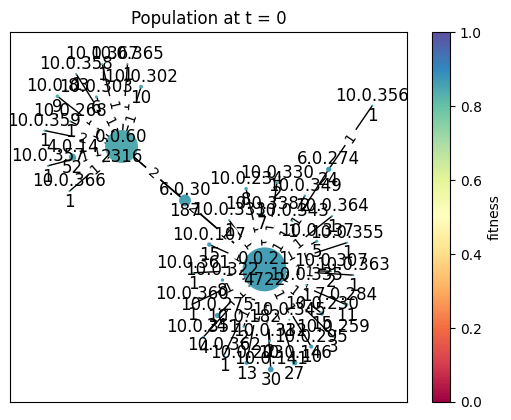

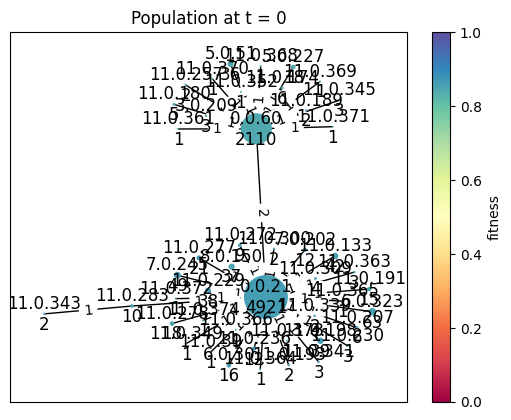

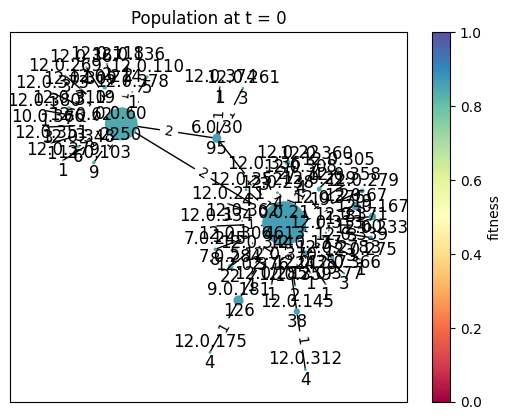

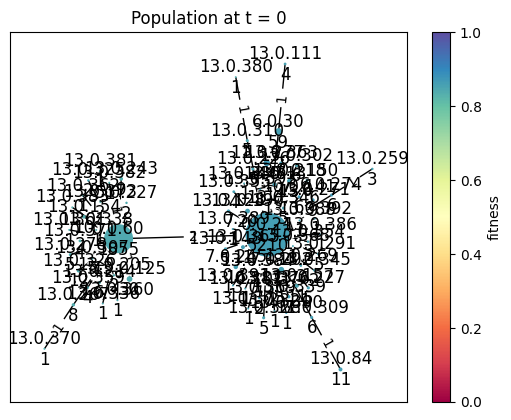

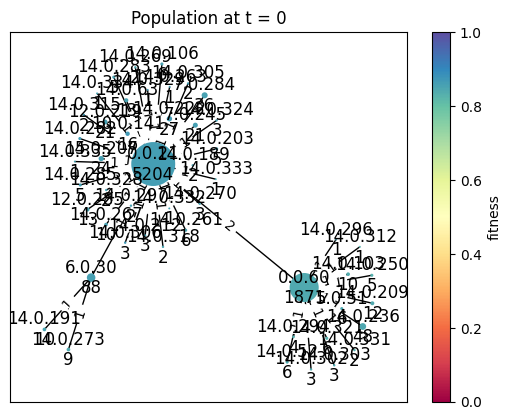

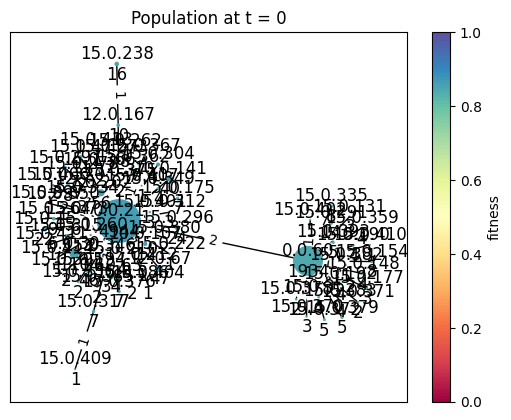

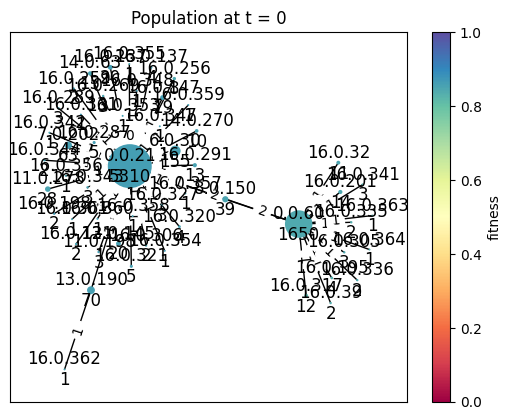

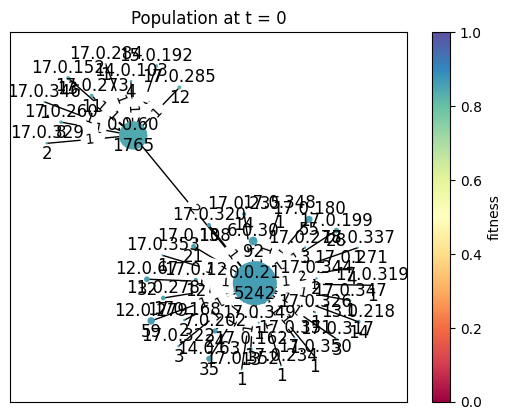

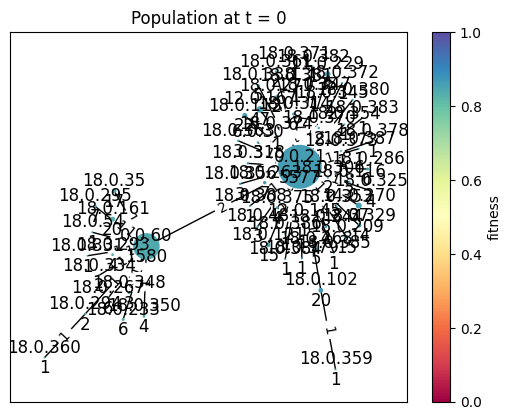

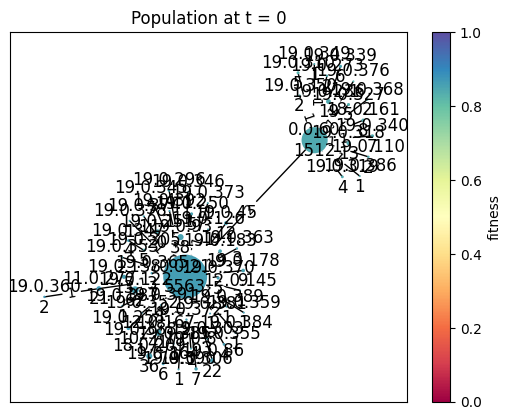

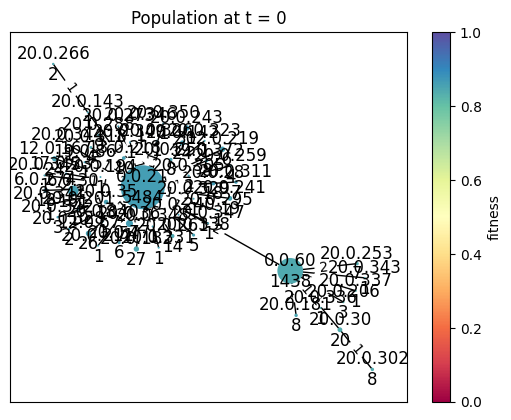

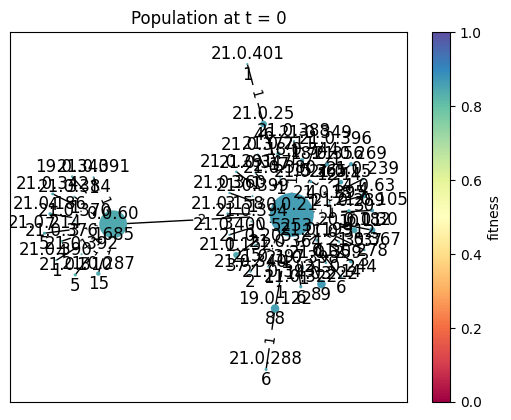

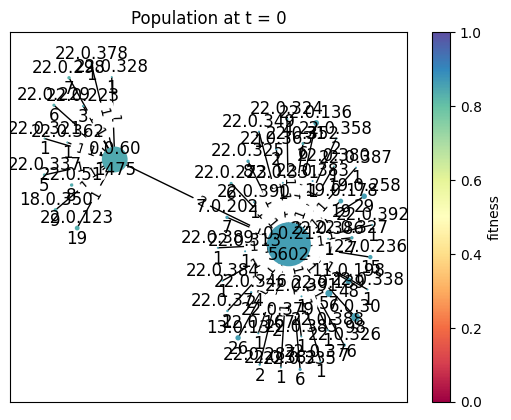

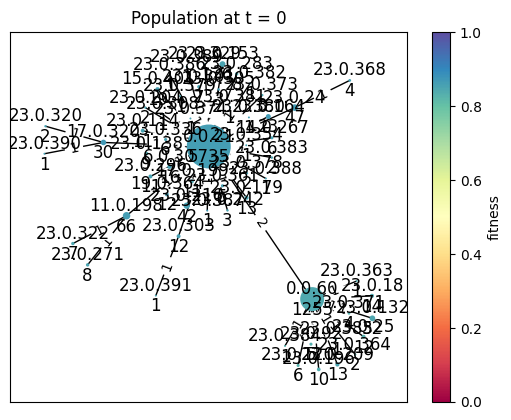

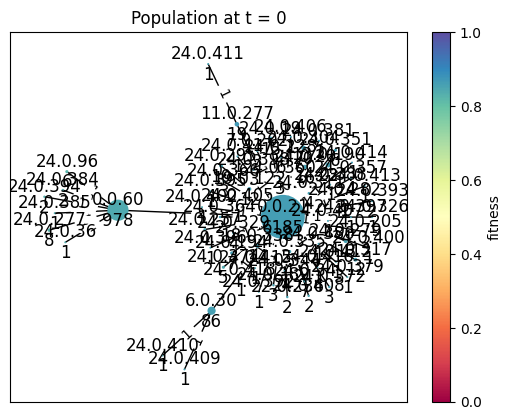

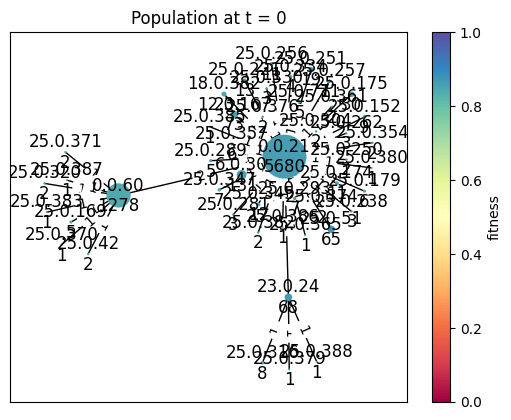

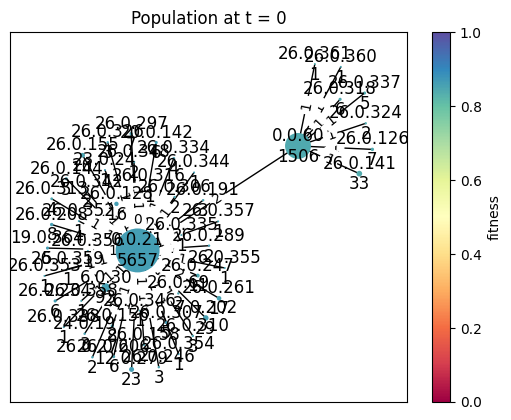

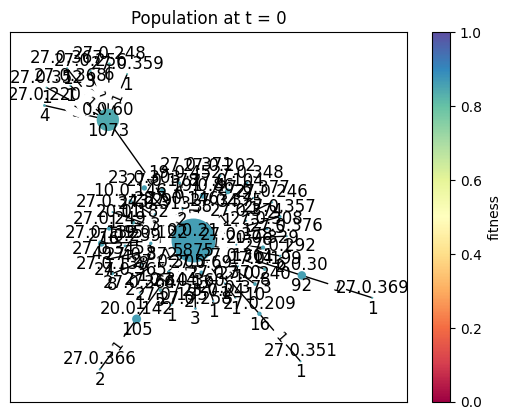

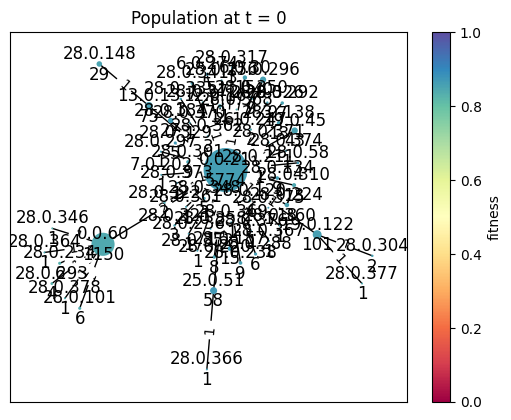

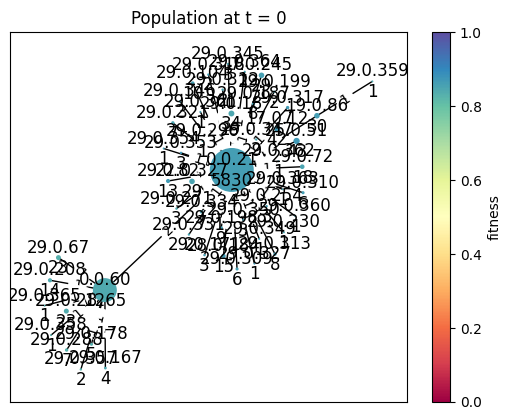

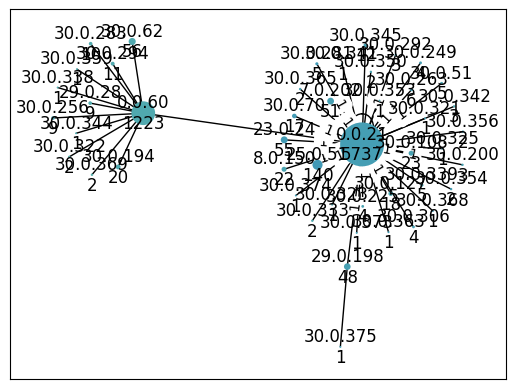

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from project_package.plot import rescale
abundance_threshold=0
transparency_threshold=0
show_empty=False
view_node_labels=True
view_edge_labels=True
abundance_threshold=1
transparency_threshold='100%'
replace_title=False
from project_package.simplify import remove_empty_leaves_and_rescale_edges

# for i in range(len(time_series_hostassociated)):
for i in [0,1]:
    for G in time_series_hostassociated[i]:
        if len(G.nodes(data=True))==0:
            continue
        print(G.nodes(data=True))
        plt.figure()

        visualize_pop(G)

In [60]:
time_series_hostassociated

{0: [<networkx.classes.graph.Graph at 0x1416bc0d0>,
 1: [<networkx.classes.graph.Graph at 0x141721190>,
 2: [<networkx.classes.graph.Graph at 0x1454ff790>,
 3: [<networkx.classes.graph.Graph at 0x1416f6ed0>,
 4: [<networkx.classes.graph.Graph at 0x1413b21d0>,
  <networkx.classes.graph.Graph at 0x14211d3d0>]}

## high escape rate

In [ ]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
#sys.path.append("/home/qiulab/data/CRF_project/work/Modeling_trophosome/src/")

from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.update_pop import update_pop3
from project_package.run_model import run_generation_of_host_pop
from project_package.plot import visualize_pop
from project_package.simplify import merge_graphs

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time


# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-12
growth_factor=1.2
steady_state_runtime=50
max_runtime=np.inf
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

## params run_host_pop_gen
n_worms=10
infection_sym_count=10
tot_host_pop_gen=100
escape_rate=1E-1
n_trials=5
cpus=4

# init tree log-fisher
init_pop_strains=100000
is_init_pop_log_fisher=True

if is_init_pop_log_fisher==True:  
    freelivingG=generate_random_fisherlog_pop_unlinked(i=init_pop_strains) #n=individuals, i=strains
    freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(init_pop_strains)]))
    
## init tree

# fitnesses=[0.95,0.9] # allele_id:fitness
# abundances=[300000000,700000000] # allele_id:abundance # total 1G cells
# freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
# freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG




myparams=['## params grow_and_steady',
'mutation_rate='+str(mutation_rate),
'growth_factor='+str(growth_factor),
'steady_state_runtime='+str(steady_state_runtime),
'max_runtime='+str(max_runtime),
'pop_size_thr='+str(pop_size_thr),
'simplify='+str(simplify),
'verbose='+str(verbose),
'sampling_rate='+str(sampling_rate),
'',
'## params run_host_pop_gen',
'n_worms='+str(n_worms),
'infection_sym_count='+str(infection_sym_count),
'tot_host_pop_gen='+str(tot_host_pop_gen),
'escape_rate='+str(escape_rate),
'n_trials='+str(n_trials),
'cpus='+str(cpus),
'',
'## init tree',
'fitnesses='+str(fitnesses),
'abundances='+str(abundances),
'init_pop_strains='+str(init_pop_strains),
'is_init_pop_log_fisher='+str(is_init_pop_log_fisher)]


print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


###############################
## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

start_time=time.time()

with alive_bar((tot_host_pop_gen+1) * n_trials ,force_tty=True) as bar:
    for trial in range(n_trials):
        host_pop_gen=0
        time_series_freeliving[trial]=[freelivingG]
        time_series_hostassociated[trial]=[nx.Graph()]
        myfreelivingG=freelivingG.copy()
    
        for host_pop_gen in range(1,tot_host_pop_gen+1):
        
            merged_Graph_hostassociated, merged_Graph_freeliving,_=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                 mutation_rate, steady_state_runtime,
                                 max_runtime, growth_factor=growth_factor,
                                 stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                 verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=cpus)
            
            time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
            time_series_freeliving[trial]+=[merged_Graph_freeliving]
            myfreelivingG=merged_Graph_freeliving
            
            bar() 
print('finished')

print('it took', time.time()-start_time, 'seconds')

###########


dump_dir='../examples/'
test='toy_example2_high_escaperate'

with open(dump_dir+test+'.input_params.txt', 'w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_freeliving, handle)


df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    # time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])  

import seaborn as sns

sns.lineplot(data=df,x=df.index,y='richness',hue='metapop')
plt.savefig(dump_dir+test+".plot.svg", format='svg')

## high mutation rate

In [ ]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
#sys.path.append("/home/qiulab/data/CRF_project/work/Modeling_trophosome/src/")

from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.update_pop import update_pop3
from project_package.run_model import run_generation_of_host_pop
from project_package.plot import visualize_pop
from project_package.simplify import merge_graphs

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time


# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-8
growth_factor=1.2
steady_state_runtime=50
max_runtime=np.inf
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

## params run_host_pop_gen
n_worms=10
infection_sym_count=10
tot_host_pop_gen=100
escape_rate=1E-2
n_trials=5
cpus=4

# init tree log-fisher
fitnesses=[]
abundances=[]
init_pop_strains=100
is_init_pop_log_fisher=True

if is_init_pop_log_fisher==True:  
    freelivingG=generate_random_fisherlog_pop_unlinked(i=init_pop_strains) #n=individuals, i=strains
    freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(init_pop_strains)]))
    
## init tree

# fitnesses=[0.95,0.9] # allele_id:fitness
# abundances=[300000000,700000000] # allele_id:abundance # total 1G cells
# freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
# freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG




myparams=['## params grow_and_steady',
'mutation_rate='+str(mutation_rate),
'growth_factor='+str(growth_factor),
'steady_state_runtime='+str(steady_state_runtime),
'max_runtime='+str(max_runtime),
'pop_size_thr='+str(pop_size_thr),
'simplify='+str(simplify),
'verbose='+str(verbose),
'sampling_rate='+str(sampling_rate),
'',
'## params run_host_pop_gen',
'n_worms='+str(n_worms),
'infection_sym_count='+str(infection_sym_count),
'tot_host_pop_gen='+str(tot_host_pop_gen),
'escape_rate='+str(escape_rate),
'n_trials='+str(n_trials),
'cpus='+str(cpus),
'',
'## init tree',
'fitnesses='+str(fitnesses),
'abundances='+str(abundances),
'init_pop_strains='+str(init_pop_strains),
'is_init_pop_log_fisher='+str(is_init_pop_log_fisher)]


print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


###############################
## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

start_time=time.time()

with alive_bar((tot_host_pop_gen+1) * n_trials ,force_tty=True) as bar:
    for trial in range(n_trials):
        host_pop_gen=0
        time_series_freeliving[trial]=[freelivingG]
        time_series_hostassociated[trial]=[nx.Graph()]
        myfreelivingG=freelivingG.copy()
    
        for host_pop_gen in range(1,tot_host_pop_gen+1):
        
            merged_Graph_hostassociated, merged_Graph_freeliving,_=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                 mutation_rate, steady_state_runtime,
                                 max_runtime, growth_factor=growth_factor,
                                 stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                 verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=cpus)
            
            time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
            time_series_freeliving[trial]+=[merged_Graph_freeliving]
            myfreelivingG=merged_Graph_freeliving
            
            bar() 
print('finished')

print('it took', time.time()-start_time, 'seconds')

###########


dump_dir='../examples/'
test='toy_example2_high_mutationrate'

with open(dump_dir+test+'.input_params.txt', 'w') as fa:
    fa.write('\n'.join(myparams))

with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)

with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
  pickle.dump(time_series_hostassociated, handle)


df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    # time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])  

import seaborn as sns

sns.lineplot(data=df,x=df.index,y='richness',hue='metapop')
plt.savefig(dump_dir+test+".plot.svg", format='svg')